### "Шапка" с названием проекта

В этой ячейке вы найдете оглавление и ключевые этапы работы, которые помогут вам ориентироваться в процессе выполнения проекта. Проект разделен на пять основных этапов, четыре из которых (этапы 2, 3, 4 и 5) вам предлагается выполнить в этом Jupyter Notebook:

- Подготовка среды MLflow - Первый шаг, подготовка и запуск сервисов MLflow, был выполнен вне ноутбука и оформлен в виде Python скрипта. Это основа для работы с экспериментами и логирования результатов ваших моделей.

- Этап 2 - Исследовательский Анализ Данных (EDA): На этом этапе вы проведете тщательный анализ данных, чтобы лучше понять их структуру и особенности.

- Этап 3 - Генерация Признаков и Обучение Модели: После анализа данных вы сгенерируете новые признаки и обучите модель, используя эти признаки.

- Этап 4 - Отбор Признаков и Обучение Модели: На этом шаге вы отберете наиболее значимые признаки и снова обучите модель для улучшения ее качества.

- Этап 5 - Подбор Гиперпараметров и Обучение Финальной Версии Модели: Финальный этап проекта посвящен оптимизации гиперпараметров для достижения максимального качества модели.

Для удобства навигации и организации работы, пожалуйста, следуйте оглавлению и рекомендациям, описанным в каждом этапе.

> ### Важно: Переобучение моделей
> На каждом этапе проекта, где требуется переобучение модели, важно не просто выполнить эту процедуру, но и тщательно проверить качество модели на соответствующих выборках. Это включает в себя анализ метрик качества, визуализацию результатов, сравнение с предыдущими моделями и, при необходимости, корректировку.

#### Этап 2: Исследовательский Анализ Данных (EDA)
На этом этапе ваша задача - провести тщательный исследовательский анализ данных (EDA), чтобы глубже понять особенности и связи в предоставленном наборе данных. В процессе EDA вы должны обратить внимание на три ключевых аспекта, о которых мы говорили в теме 3 курса. Очень важно, чтобы все результаты вашего исследования, включая визуализации, статистический анализ и предварительные выводы, были аккуратно залогированы в MLflow.

Для более организованного исследования предлагаем следующие рекомендуемые шаги:
- Понимание данных: Первоначально ознакомьтесь с данными, изучите типы данных, проверьте наличие пропущенных значений.
- Визуализация данных: Используйте графики и диаграммы для визуализации распределений признаков и возможных взаимосвязей между ними.
- Статистический анализ: Примените статистические методы для изучения центральных тенденций, разброса и корреляций между признаками.
- Предварительные выводы: На основе проведённого анализа сформулируйте предварительные выводы о данных, которые помогут в дальнейшем этапе моделирования.

Помните, что EDA - это итеративный процесс, в котором вы можете возвращаться к предыдущим шагам для дополнительного анализа, если это будет необходимо. Все находки и выводы должны быть чётко зафиксированы и легко доступны для команды проекта.


##### Импорт библиотек

In [1]:
import os
import psycopg2 as psycopg
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import math
from pathlib import Path

import mlflow




##### 2.1 Загрузка данных

In [2]:
connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.environ["DB_DESTINATION_HOST"], 
    "port": os.environ["DB_DESTINATION_PORT"],
    "dbname": os.environ["DB_DESTINATION_NAME"],
    "user": os.environ["DB_DESTINATION_USER"],
    "password": os.environ["DB_DESTINATION_PASSWORD"],
}

assert all([var_value != "" for var_value in list(postgres_credentials.values())])

connection.update(postgres_credentials)

# определим название таблицы, в которой хранятся наши данные.
TABLE_NAME = "clean_real_estate"

# эта конструкция создаёт контекстное управление для соединения с базой данных 
# оператор with гарантирует, что соединение будет корректно закрыто после выполнения всех операций 
# закрыто оно будет даже в случае ошибки, чтобы не допустить "утечку памяти"
with psycopg.connect(**connection) as conn:

# создаёт объект курсора для выполнения запросов к базе данных
# с помощью метода execute() выполняется SQL-запрос для выборки данных из таблицы TABLE_NAME
    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
                
                # извлекаем все строки, полученные в результате выполнения запроса
        data = cur.fetchall()

                # получает список имён столбцов из объекта курсора
        columns = [col[0] for col in cur.description]

# создаёт объект DataFrame из полученных данных и имён столбцов. 
# это позволяет удобно работать с данными в Python, используя библиотеку Pandas.
re_df = pd.DataFrame(data, columns=columns)
re_df

flat_id  floor is_apartment  kitchen_area  living_area  rooms   
0         10769      9        false      8.946669    33.000000      2  \
1         10770      3        false      7.600000    37.299999      2   
2         10771     18        false     13.200000    24.000000      1   
3         10773      3        false     11.000000    14.700000      1   
4         10774      3        false      7.500000    22.500000      2   
...         ...    ...          ...           ...          ...    ...   
118803   141357     16        false     11.000000    18.000000      1   
118804   141358      5        false      5.280000    28.330000      2   
118805   141359      7        false      5.300000    20.000000      1   
118806   141360     15        false     13.800000    33.700001      2   
118807   141361     16        false      7.600000    18.000000      1   

        total_area  building_id  build_year  building_type_int   latitude   
0        43.900002         4431        1962                  4  55.705067  \
1        58.900002         1858        1957                  1  55.738945   
2        54.700001        20908        2008                  2  55.809341   
3        34.099998        17563        1999                  4  55.858074   
4        37.799999         6528        1966                  4  55.713547   
...            ...          ...         ...                ...        ...   
118803   42.000000        22455        2013                  4  55.626579   
118804   41.110001         3162        1960                  1  55.727470   
118805   31.500000         6513        1966                  4  55.704315   
118806   65.300003        23952        2017                  4  55.699863   
118807   38.000000        15104        1988                  4  55.862133   

        longitude  ceiling_height  flats_count  floors_total has_elevator   
0       37.763611            2.64           72             9         true  \
1       37.521091            3.00           91             8         true   
2       37.455643            2.80          528            26         true   
3       37.568119            2.75           77            12         true   
4       37.642311            2.64           72             9         true   
...           ...             ...          ...           ...          ...   
118803  37.313503            2.64          672            25         true   
118804  37.768677            2.48           80             5        false   
118805  37.506584            2.64           72             9         true   
118806  37.939564            2.70          480            25         true   
118807  37.689613            2.74          128            17         true   

             price  
0       10000000.0  
1       17950000.0  
2       14200000.0  
3        9950000.0  
4        9650000.0  
...            ...  
118803  10500000.0  
118804   7400000.0  
118805   9700000.0  
118806  11750000.0  
118807   8000000.0  

[118808 rows x 17 columns]

In [3]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" #endpoint бакета от YandexCloud
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") # получаем id ключа бакета, к которому подключён MLFlow, из .env
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY") # получаем ключ бакета, к которому подключён MLFlow, из .env

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

registry_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"
tracking_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"

mlflow.set_tracking_uri(tracking_uri)

In [4]:
ASSETS_DIR = 'assets'
Path(ASSETS_DIR).mkdir(parents=True, exist_ok=True)

EXPERIMENT_NAME = "estate_project"
RUN_NAME = "baseline"
REGISTRY_MODEL_NAME = "estate_model"


##### 2.2. Общий обзор датасета

In [5]:
re_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118808 entries, 0 to 118807
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   flat_id            118808 non-null  int64  
 1   floor              118808 non-null  int64  
 2   is_apartment       118808 non-null  object 
 3   kitchen_area       118808 non-null  float64
 4   living_area        118808 non-null  float64
 5   rooms              118808 non-null  int64  
 6   total_area         118808 non-null  float64
 7   building_id        118808 non-null  int64  
 8   build_year         118808 non-null  int64  
 9   building_type_int  118808 non-null  int64  
 10  latitude           118808 non-null  float64
 11  longitude          118808 non-null  float64
 12  ceiling_height     118808 non-null  float64
 13  flats_count        118808 non-null  int64  
 14  floors_total       118808 non-null  int64  
 15  has_elevator       118808 non-null  object 
 16  pr

In [6]:
features = re_df.drop(columns=['flat_id','building_id', 'price'])
num_features = features.select_dtypes(include=['int64', 'float64']).drop(columns=['building_type_int'])
cat_features = features.select_dtypes(include=['object'])
cat_features = pd.concat([cat_features, re_df['building_type_int']], axis=1)

In [7]:
num_features.describe()

floor   kitchen_area    living_area          rooms   
count  118808.000000  118808.000000  118808.000000  118808.000000  \
mean        7.479656       9.703033      34.925627       2.147498   
std         5.695665       4.460143      20.536334       0.982595   
min         1.000000       1.500000       2.000000       1.000000   
25%         3.000000       7.000000      21.000000       1.000000   
50%         6.000000       8.946669      30.874632       2.000000   
75%        10.000000      10.200000      42.000000       3.000000   
max        56.000000     203.000000     700.000000      20.000000   

          total_area     build_year       latitude      longitude   
count  118808.000000  118808.000000  118808.000000  118808.000000  \
mean       62.478277    1986.467948      55.730796      37.589257   
std        39.318210      21.987232       0.103136       0.150774   
min        11.500000    1901.000000      55.211460      36.864372   
25%        40.000000    1969.000000      55.654347      37.491837   
50%        53.400002    1985.000000      55.725143      37.581438   
75%        72.000000    2006.000000      55.808743      37.692562   
max       960.299988    2023.000000      56.011032      37.946411   

       ceiling_height    flats_count   floors_total  
count   118808.000000  118808.000000  118808.000000  
mean         2.751281     251.560316      14.091088  
std          0.210963     206.803942       6.880000  
min          2.000000       1.000000       1.000000  
25%          2.640000     111.000000       9.000000  
50%          2.640000     199.000000      14.000000  
75%          2.800000     323.000000      17.000000  
max          8.000000    4455.000000      99.000000

In [8]:
cat_features.nunique()

is_apartment         2
has_elevator         2
building_type_int    7
dtype: int64

##### 2.3 Анализ признаков для модели

In [9]:
x = 'building_type_int'
charges_columns = num_features.columns
stats=['mean','std']
building_type_agg = re_df[[x] + [num_features.columns[0]]].groupby([x]).agg(stats).reset_index() 
building_type_agg.columns = building_type_agg.columns.droplevel()
building_type_agg.columns = [x, num_features.columns[0]+"_mean", num_features.columns[0]+"_std"]
for col in num_features.columns[1:]:
    building_type_agg_col = re_df[[x] + [col]].groupby([x]).agg(stats).reset_index() 
    #building_type_agg_col.columns = building_type_agg.columns.droplevel()
    building_type_agg_col.columns = [x, col+"_mean", col+"_std"]
    building_type_agg_col.drop(columns=x, inplace=True)
    building_type_agg = pd.concat([building_type_agg, building_type_agg_col], axis=1)
building_type_agg


building_type_int  floor_mean  floor_std  kitchen_area_mean   
0                  0    6.833229   5.767824          10.889359  \
1                  1    4.554750   3.041415           9.004594   
2                  2   10.993605   8.032992          13.539324   
3                  3    8.904897   8.085360          14.894846   
4                  4    7.408183   4.912566           8.782401   
5                  5    1.750000   0.957427          12.075000   
6                  6    6.084206   3.879882           8.121565   

   kitchen_area_std  living_area_mean  living_area_std  rooms_mean  rooms_std   
0          8.428582         40.989870        36.176067    2.278576   1.140108  \
1          4.500338         38.799248        23.068220    2.368873   1.042765   
2          6.510821         43.713300        31.010404    2.430976   1.173581   
3          8.865138         61.453556        51.207274    3.151171   1.429399   
4          2.377497         31.434084        11.565308    2.022664   0.858076   
5          6.139150         36.700000        20.061406    2.000000   0.816497   
6          2.425924         26.777348         8.915675    1.753462   0.702881   

   total_area_mean  ...  latitude_mean  latitude_std  longitude_mean   
0        76.199325  ...      55.728258      0.108799       37.582708  \
1        66.076467  ...      55.755879      0.069303       37.602694   
2        88.946065  ...      55.713018      0.101819       37.524038   
3       150.350830  ...      55.718946      0.085911       37.533599   
4        53.498262  ...      55.725769      0.111946       37.601402   
5        64.575000  ...      55.681970      0.141379       37.298787   
6        43.622954  ...      55.757604      0.084089       37.631517   

   longitude_std  ceiling_height_mean  ceiling_height_std  flats_count_mean   
0       0.141338             2.759400            0.229274        252.636477  \
1       0.105589             2.887052            0.294923        139.610863   
2       0.122707             2.956216            0.171454        357.864163   
3       0.134187             3.121561            0.247758        257.381121   
4       0.167184             2.657932            0.088499        269.268948   
5       0.070918             3.175000            0.221736          5.000000   
6       0.119908             2.614553            0.115971        113.796240   

   flats_count_std  floors_total_mean  floors_total_std  
0       312.842559          12.846346          7.589228  
1       127.834632           8.198632          3.843032  
2       319.646140          20.817762          9.215432  
3       267.249589          16.784244         11.573947  
4       157.321639          14.028798          4.739215  
5         3.366502           2.250000          1.258306  
6        84.139282          11.509850          3.412593  

[7 rows x 23 columns]

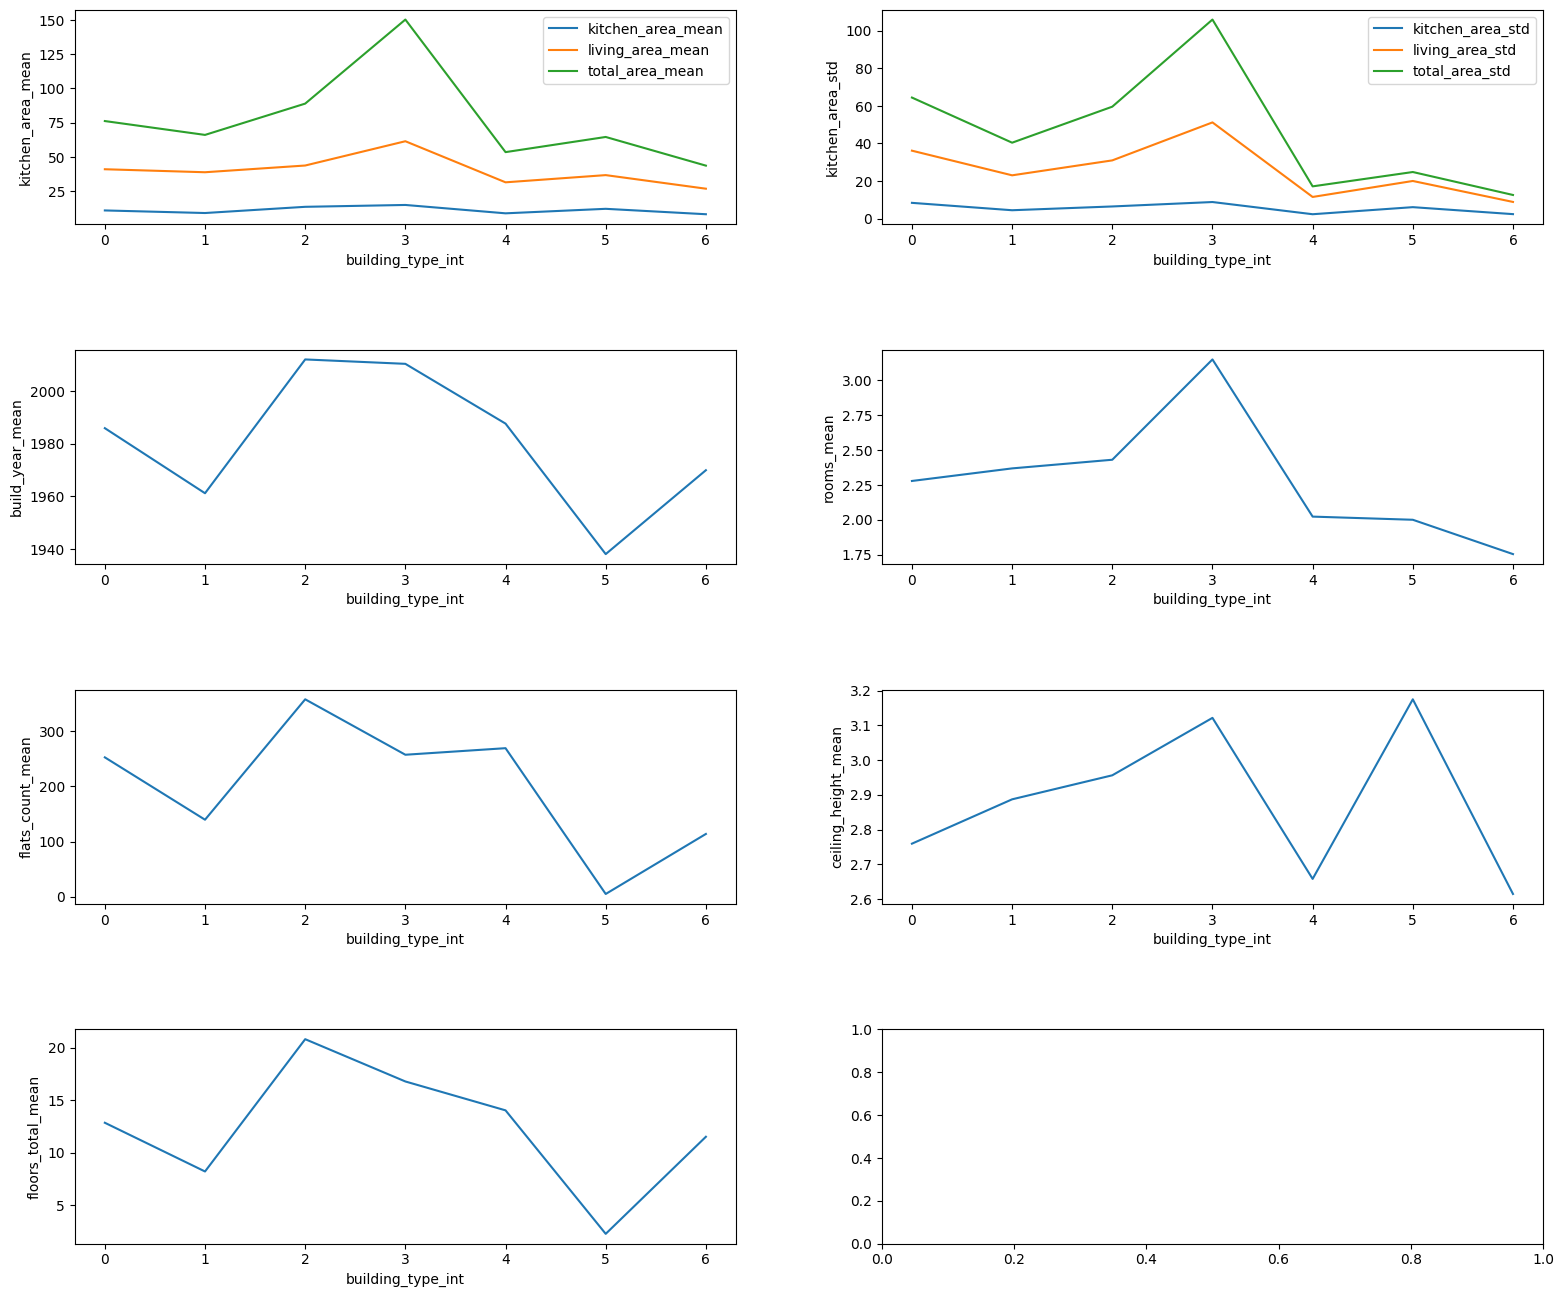

In [10]:

fig, axs = plt.subplots(4,2)
fig.tight_layout(pad=1)
fig.set_size_inches(16.5, 14 ,forward=True)

for col in [x for x in  building_type_agg.columns if 'area_mean' in x]:
    sns.lineplot(building_type_agg,x=x,y=col, ax=axs[0,0],label=col)

for col in [x for x in  building_type_agg.columns if 'area_std' in x]:
    sns.lineplot(building_type_agg,x=x,y=col, ax=axs[0,1],label=col)

sns.lineplot(building_type_agg,x=x,y='build_year_mean', ax=axs[1,0])

sns.lineplot(building_type_agg,x=x,y='rooms_mean', ax=axs[1,1])
sns.lineplot(building_type_agg,x=x,y='flats_count_mean', ax=axs[2,0])
sns.lineplot(building_type_agg,x=x,y='ceiling_height_mean', ax=axs[2,1])
sns.lineplot(building_type_agg,x=x,y='floors_total_mean', ax=axs[3,0])




# В целом, видно что каждый building_type характерен своими признаками. Можно предположить, что:
# building_type_int = 3 - частные дома с большой площадью
# building_type_int = 4 - относительно новые дома с низкими потолками и малой площадью. Вероятно квартиры-студии
# building_type_int = 5 - "сталинки" с высокими потолками и старой постройкой 

plt.savefig(os.path.join(ASSETS_DIR, 'building_type_int-numeric_columns'))


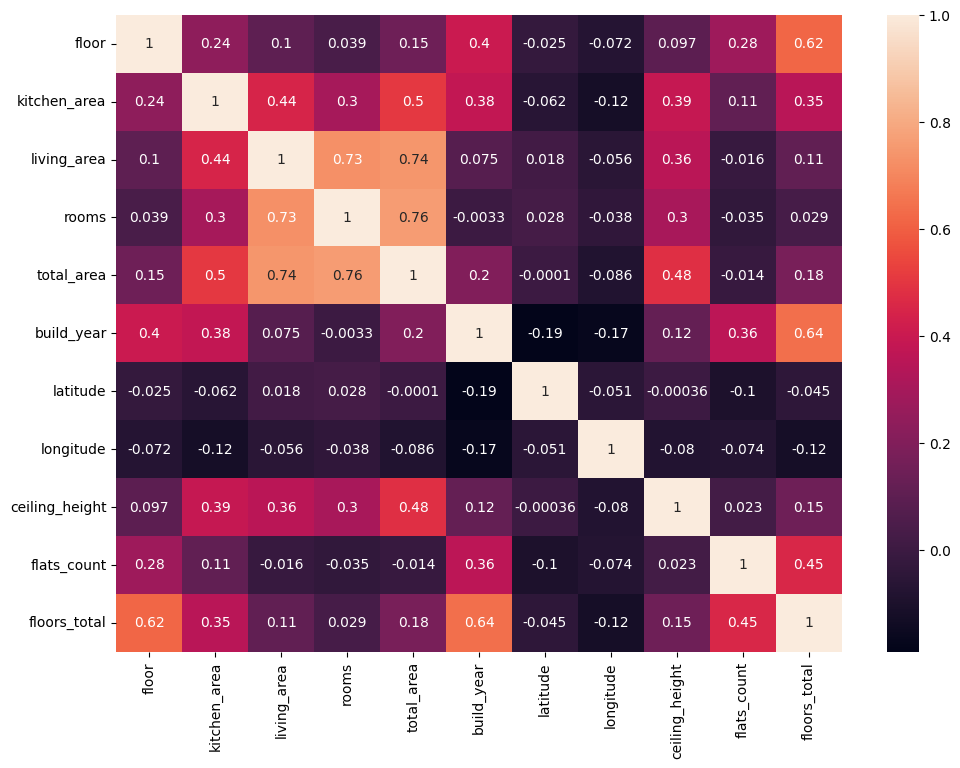

In [11]:
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27
feature_correlation = num_features.corr()
sns.heatmap(feature_correlation, annot=True)
plt.savefig(os.path.join(ASSETS_DIR, 'numeric_columns_correlation'))

# В целом, сильно коррелирующих признаков нет. Можно отметить лишь следующее:
# Достаточно сильная корреляция между количеством комнат, жилой и общей площадью (что логично). Вероятно стоит оставить только одну общую площадь
# Средняя корреляция между годом постройки и количеством этажей

In [12]:
floor_locality = re_df['floors_total']/re_df['floor']
floor_locality.describe()
# 

count    118808.000000
mean          3.070429
std           3.059160
min           1.000000
25%           1.272727
50%           1.857143
75%           3.500000
max          40.000000
dtype: float64

##### 2.4 Анализ целевой переменной

In [13]:
re_df['price']  = re_df['price'].astype('int')


In [14]:
re_df['price'].describe()

count    1.188080e+05
mean     1.931485e+07
std      6.990619e+07
min      1.100000e+01
25%      8.999999e+06
50%      1.190000e+07
75%      1.690000e+07
max      9.873738e+09
Name: price, dtype: float64

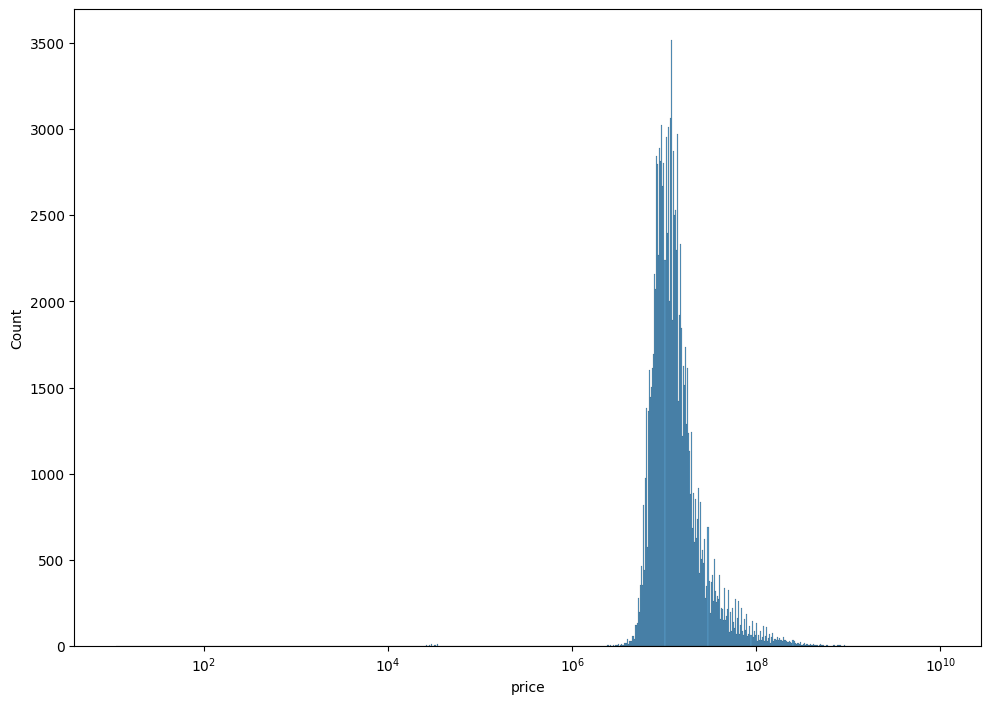

In [15]:
sns.histplot(data=re_df, x='price',log_scale=True)
plt.savefig(os.path.join(ASSETS_DIR, 'price_histogram'))

In [16]:
re_df.loc[re_df['price'] < 1000000]
# Странные цены на квартиры - то ли указаны в долларах, то ли это доля от квартиры, то ли что-то еще. Вероятно, будут влиять на качество. неплохо бы понять, имеется ли тут ошибка в цене.

flat_id  floor is_apartment  kitchen_area  living_area  rooms   
10105      1572     12        false           9.7         33.0      2  \
10693     10471     12        false           9.0         22.0      1   
10746     10533      6        false          12.0         30.0      1   
10785     10628     12        false          10.0         19.0      1   
13165     15608      4        false          25.0        110.0      4   
...         ...    ...          ...           ...          ...    ...   
114633   136930      8        false           9.0         30.0      2   
114685   136983      5        false          13.0         34.0      2   
114861   137162      4        false           9.0         20.0      1   
114992   137296      8        false           9.0         32.0      2   
115041   137346      8        false           8.0         50.0      1   

        total_area  building_id  build_year  building_type_int   latitude   
10105    53.700001        21366        2009                  4  55.651024  \
10693    40.000000        14289        1985                  4  55.625828   
10746    60.000000        16757        1997                  4  55.535595   
10785    36.000000        22586        2014                  2  55.431023   
13165   135.000000          950        1940                  1  55.772644   
...            ...          ...         ...                ...        ...   
114633   50.000000        16092        1994                  4  55.834518   
114685   60.000000        22519        2013                  4  55.708416   
114861   40.000000         6439        1966                  1  55.844582   
114992   54.000000        11602        1976                  4  55.609745   
115041   68.000000        11343        1975                  4  55.863873   

        longitude  ceiling_height  flats_count  floors_total has_elevator   
10105   37.343372            2.64          180            17         true  \
10693   37.718166            2.64          223            17         true   
10746   37.534191            2.64          152             6         true   
10785   36.865036            2.80          204            17         true   
13165   37.591045            3.20          135             8         true   
...           ...             ...          ...           ...          ...   
114633  37.450272            2.64          127            17         true   
114685  37.928974            2.70          183            17         true   
114861  37.491531            2.48          198             5        false   
114992  37.516781            2.64          721            16         true   
115041  37.617760            2.64          142            10         true   

         price  
10105    11200  
10693    30000  
10746    33000  
10785    16000  
13165   152000  
...        ...  
114633   42000  
114685    6800  
114861    2400  
114992   37000  
115041   15000  

[131 rows x 17 columns]

##### 2.4 Анализ целевой переменной в зависимости от различных признаков

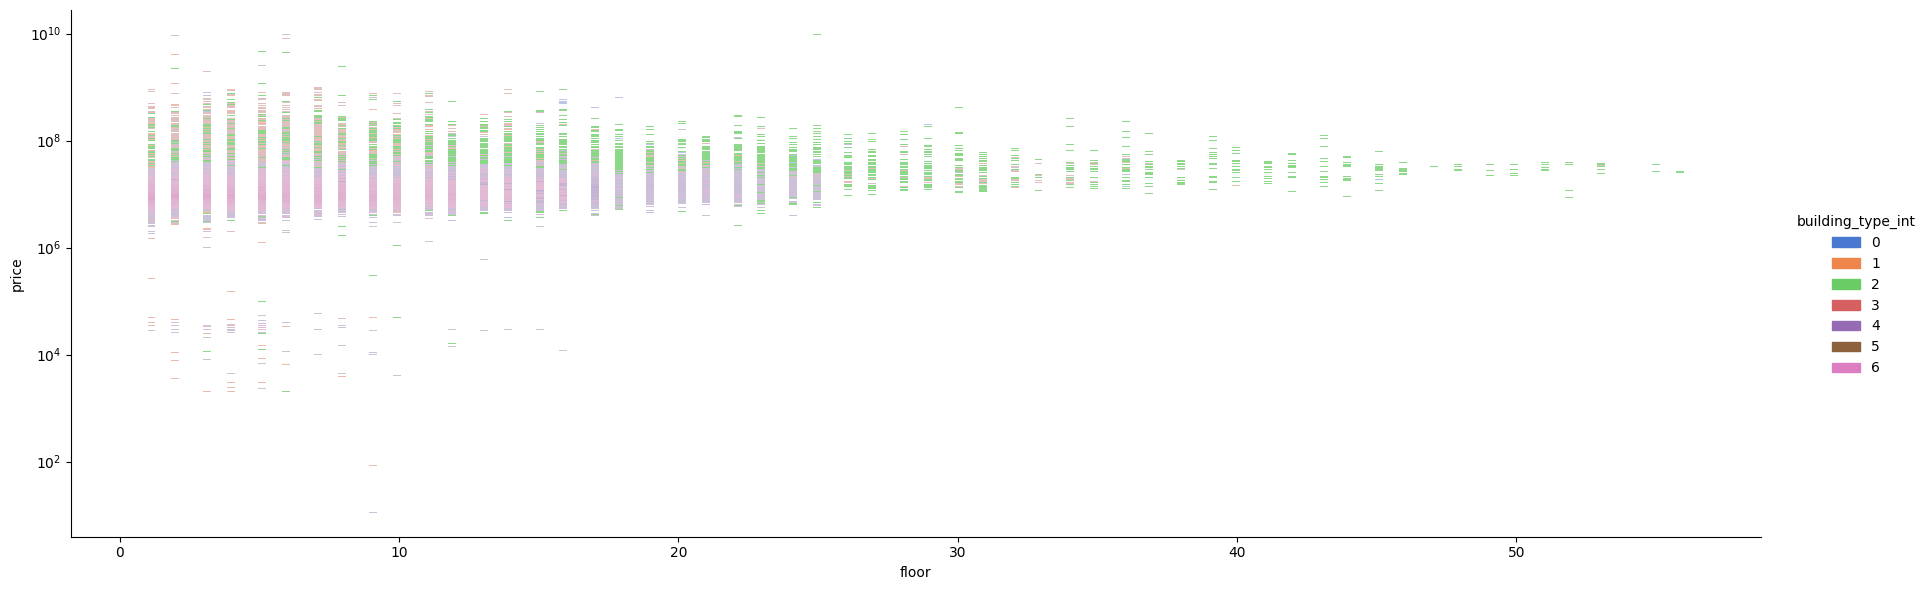

In [17]:
sns.displot(data=re_df, x ='floor', y='price', hue='building_type_int', height=6, aspect=3,log_scale=[False, True], palette='muted')
plt.savefig(os.path.join(ASSETS_DIR, 'price-floor'))
# Наблюдается кластер невысоких этажей с низкой ценой, котрый не связан с типом building_type_int

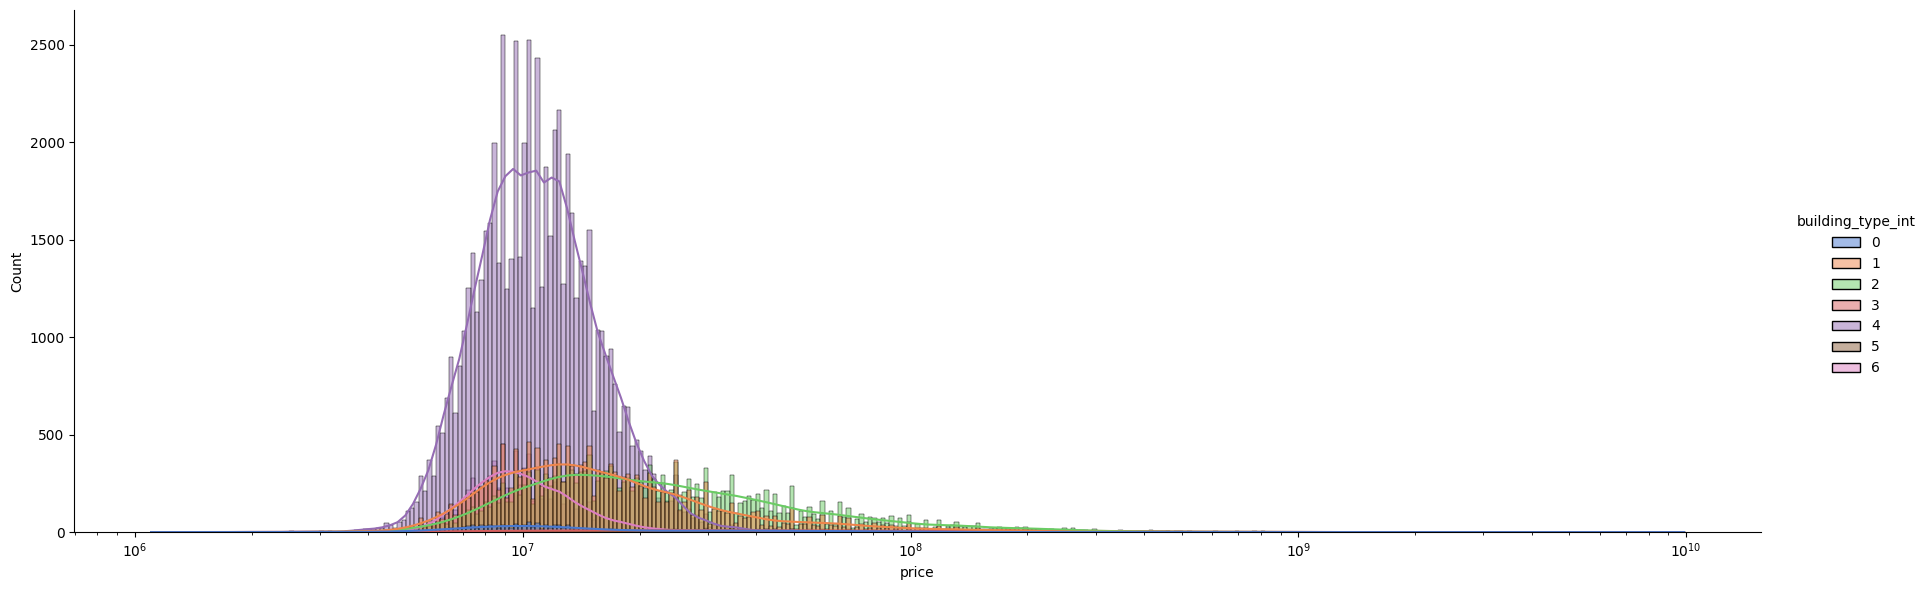

In [18]:
sns.displot(data=re_df.loc[re_df['price']>1000000], x ='price', hue='building_type_int',height=6, aspect=3, kde=True, log_scale=True,palette="muted")
plt.savefig(os.path.join(ASSETS_DIR, 'price-building_type_int'))
# Для разных групп разные распределения по цене

/tmp/ipykernel_451403/3889070763.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.displot(data=re_df.loc[re_df['price']>1000000], x ='price', y='floor', height=6, aspect=3, log_scale=[True, False],palette="muted")


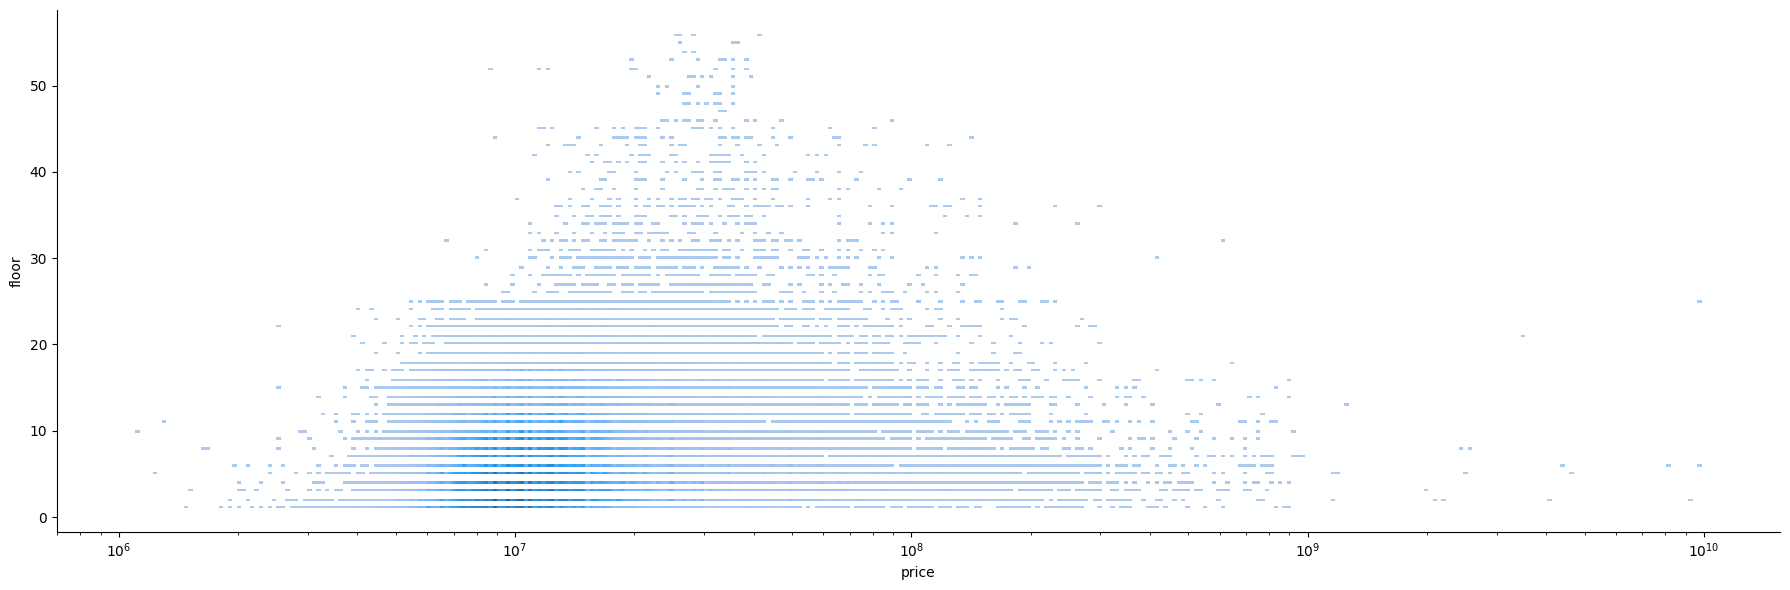

In [19]:
sns.displot(data=re_df.loc[re_df['price']>1000000], x ='price', y='floor', height=6, aspect=3, log_scale=[True, False],palette="muted")
plt.savefig(os.path.join(ASSETS_DIR, 'price-floor-2'))
# Сильной зависимости от этажа нет. Самые дорогие квартиры обычно ниже 10 этажа

/tmp/ipykernel_451403/2285426489.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.displot(data=re_df.loc[(re_df['price']>1000000) & (re_df['price']<100000000)], x ='price', y='total_area', height=6, aspect=3, log_scale=[True, False],palette="muted")


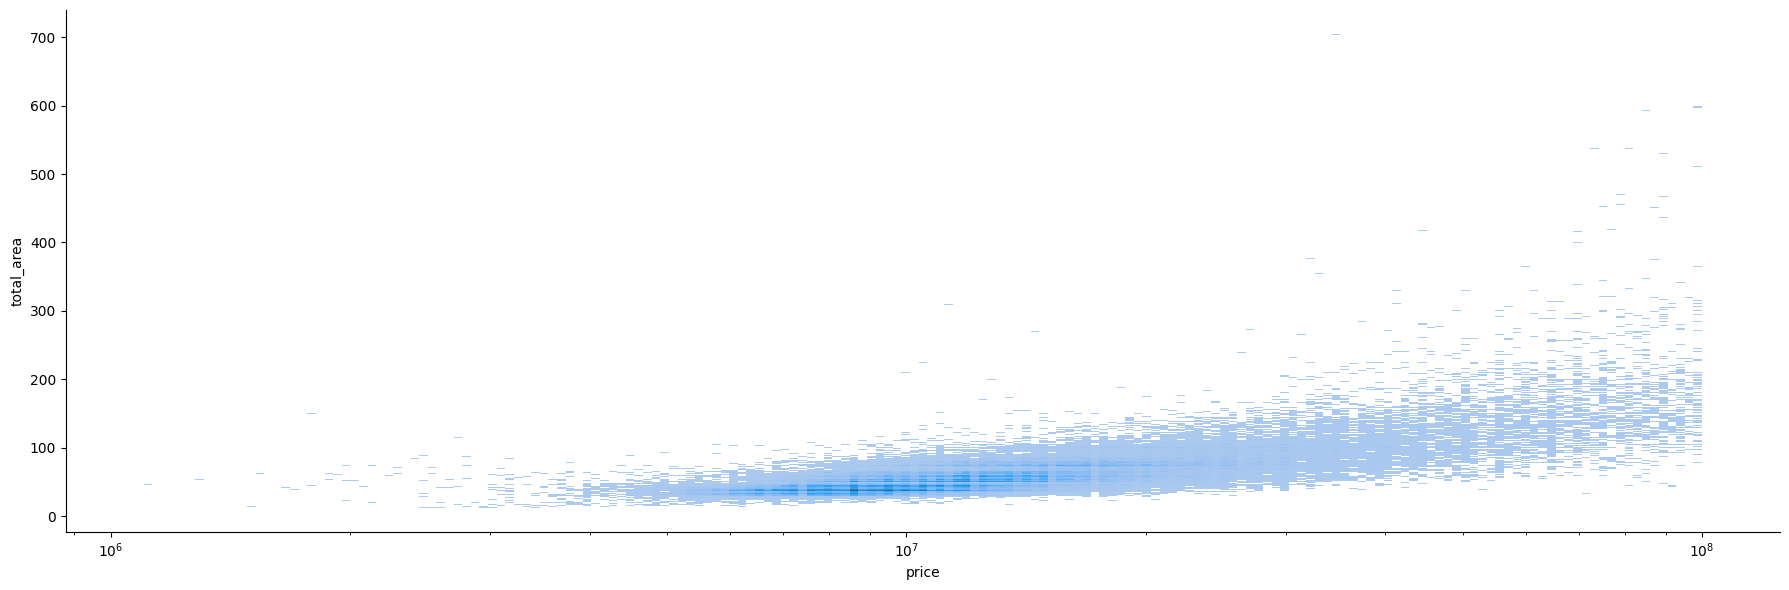

In [20]:
sns.displot(data=re_df.loc[(re_df['price']>1000000) & (re_df['price']<100000000)], x ='price', y='total_area', height=6, aspect=3, log_scale=[True, False],palette="muted")
plt.savefig(os.path.join(ASSETS_DIR, 'price-total_area'))
# При цене до 12 млн зависимости от площади квартиры практически нет. Дороже 12 млн - цена растет экспоненциально 

/tmp/ipykernel_451403/1620685074.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.displot(data=re_df.loc[(re_df['price']>1000000) & (re_df['price']<100000000)], x ='price', y=floor_locality, height=6, aspect=3, log_scale=[True, False],palette="muted")


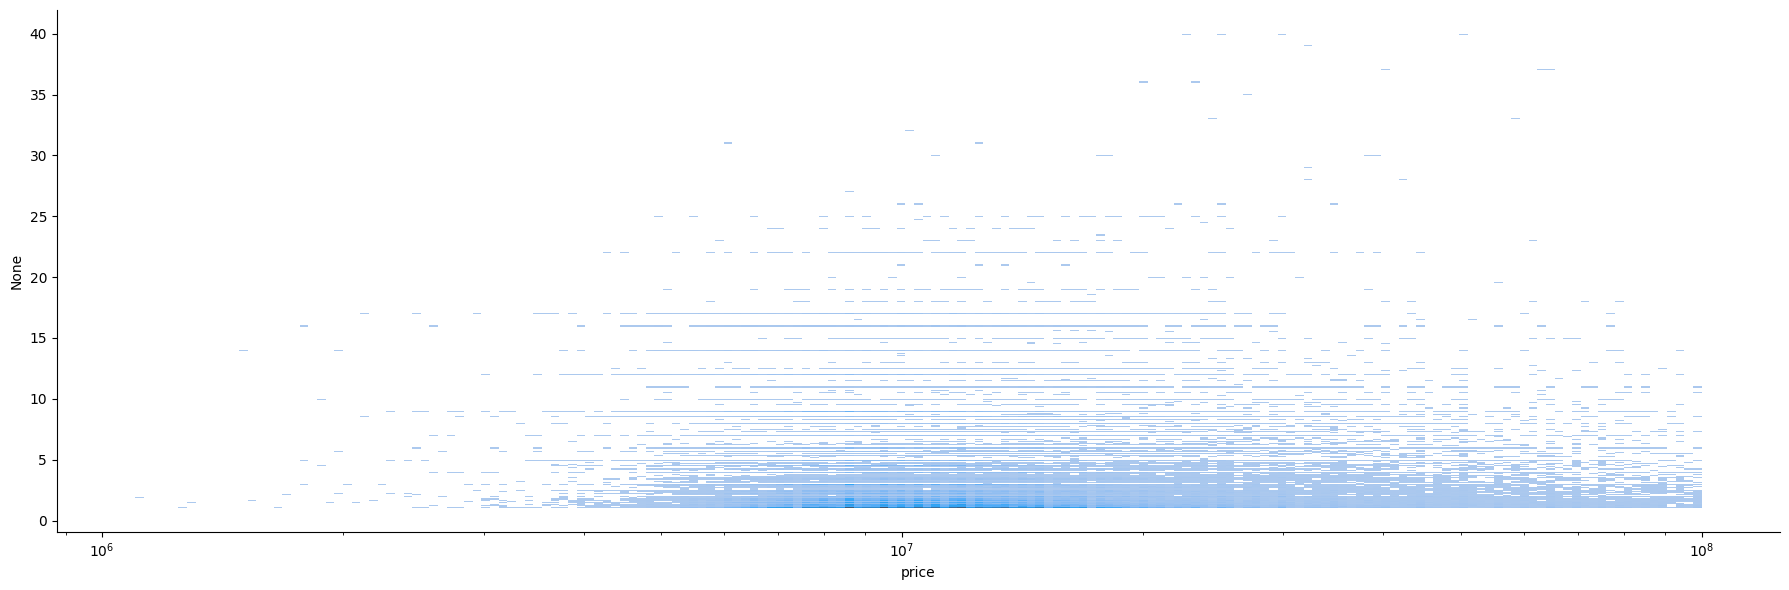

In [21]:
sns.displot(data=re_df.loc[(re_df['price']>1000000) & (re_df['price']<100000000)], x ='price', y=floor_locality, height=6, aspect=3, log_scale=[True, False],palette="muted")
# floor_locality - признак, показывающий относительное положение этажа в доме - внизу, в центре, наверху. Если равен 1 - последний этаж. Если равен  

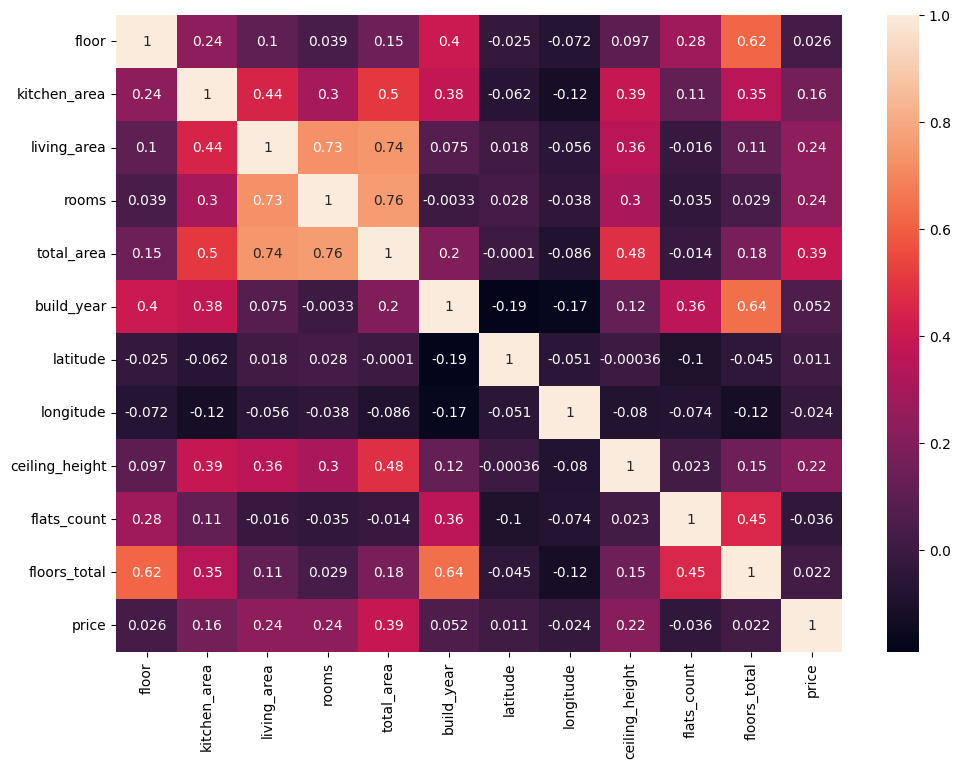

In [22]:
rcParams['figure.figsize'] = 11.7,8.27
feature_price_correlation = pd.concat([num_features, re_df['price']],axis=1).corr()
sns.heatmap(feature_price_correlation, annot=True)
plt.savefig(os.path.join(ASSETS_DIR, 'numeric_columns-price_correlation'))

# Нельзя сказать что есть набор признков, котороые сильно влияют на цену. Самая большая корреляция с ценой у площади и высоты потолков


##### 2.5 Выводы после EDA

1. В целом, видно что каждый building_type характерен своими признаками. Можно предположить, что:

    * building_type_int = 3 - частные дома с большой площадью

    * building_type_int = 4 - относительно новые дома с низкими потолками и малой площадью. Вероятно квартиры-студии

    * building_type_int = 5 - "сталинки" с высокими потолками и старой постройкой 


2. В целом, сильно коррелирующих признаков нет. Можно отметить лишь следующее:

    * Достаточно сильная корреляция между количеством комнат, жилой и общей площадью (что логично). Вероятно стоит оставить только одну общую площадь

    * Средняя корреляция между годом постройки и количеством этажей


3. Есть странные цены на квартиры - то ли указаны в долларах, то ли это доля от квартиры, то ли что-то еще. Вероятно, будут влиять на качество. неплохо бы понять, имеется ли тут ошибка в цене.


4. Наблюдается кластер невысоких этажей с низкой ценой, котрый не связан с типом ```building_type_int```


5. Для разных ```building_type_int``` разные распределения по цене


6. Сильной зависимости от этажа нет. Самые дорогие квартиры обычно ниже 10 этажа


7. При цене до 12 млн зависимости от площади квартиры практически нет. Дороже 12 млн - цена растет экспоненциально 

8. Имеет смысл выделить первый и последний этаж в отдельные переменные



##### 2.6 логирование артефактов в MLflow

In [23]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    mlflow.log_artifacts(ASSETS_DIR)
    mlflow.log_artifact('project_template_sprint_2.ipynb')

#### Этап 3: Генерация Признаков и Обучение Новой Версии Модели
После тщательного исследовательского анализа данных (EDA), вы, скорее всего, сформировали несколько гипотез относительно новых признаков, которые могут улучшить качество вашей модели. На этом этапе, мы предлагаем вам приступить к генерации новых признаков и последующему обучению модели, используя два подхода:

Ручная генерация признаков: Используйте ваше понимание данных и результаты EDA для создания новых признаков.

Автоматическая генерация признаков: Воспользуйтесь библиотеками для автоматической генерации признаков, чтобы облегчить и ускорить этот процесс.

Важно: Для признаков, созданных вручную, рекомендуется использовать объекты sklearn, такие как Pipeline и ColumnTransformer. Это позволит автоматизировать процесс преобразования данных и облегчить поддержку вашего проекта.

После генерации новых признаков, наступает время обучить новую версию вашей модели, используя эти признаки. Не забудьте залогировать все результаты, включая новые признаки, параметры модели и метрики качества, в MLflow для удобства отслеживания изменений и результатов.

Рекомендуемые шаги:

- Определение и генерация новых признаков на основе ваших гипотез.
- Использование библиотек для автоматической генерации признаков, если это применимо.
- Интеграция новых признаков в вашу модель с помощью Pipeline или ColumnTransformer для ручно созданных признаков.
- Обучение новой версии модели с использованием всех доступных признаков.
- Логирование результатов в MLflow для документирования и анализа эффективности новых признаков и модели.

Этот этап проекта критически важен для повышения точности и эффективности вашей модели. Тщательная работа на этом этапе может существенно повлиять на итоговое качество моделирования.


##### 3.1 ручная генерация признаков

In [25]:
from sklearn.preprocessing import (
    OneHotEncoder, 
    SplineTransformer, 
    QuantileTransformer, 
    RobustScaler,
    PolynomialFeatures,
    KBinsDiscretizer,
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import CatBoostEncoder
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

In [26]:
n_knots = 3
degree_spline = 4
spl_enc = SplineTransformer(n_knots=n_knots, degree=degree_spline)

In [27]:
n_quantiles = 25
q_enc = QuantileTransformer(n_quantiles=n_quantiles)

In [28]:
rb_enc = RobustScaler()

In [29]:
degree = 2
pol_enc = PolynomialFeatures(degree=degree)

In [30]:
n_bins = 5
encode = 'ordinal'
strategy = 'uniform'
subsample = None
kbd_enc = KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy, subsample=subsample)

In [31]:
re_df['is_first_floor'] = re_df['floor'] == 1
re_df['is_last_floor'] = re_df['floor'] == re_df['floors_total'] 


##### 3.2 оборачивание всех преобразований в объекты sklearn

In [32]:
features = re_df.drop(columns=['flat_id','building_id', 'price'])
num_features = features.select_dtypes(include=['int64', 'float64']).drop(columns=['building_type_int'])
cat_features = features.select_dtypes(include=['object', 'bool'])
cat_features = pd.concat([cat_features, re_df['building_type_int']], axis=1)

num_features_columns = num_features.columns
cat_features_columns = cat_features.columns

In [34]:

num_features_columns_rem = ['scaler__'+x for x in num_features_columns] 
cat_features_columns_rem = ['remainder__'+x for x in cat_features_columns] 

In [35]:

numeric_transformer = ColumnTransformer(
    transformers=[
        #('spl', spl_enc, num_features_columns),
        #('q', q_enc, num_features_columns),
        #('rb', rb_enc, num_features_columns),
        ('pol', pol_enc, num_features_columns),
        ('kbd', kbd_enc, num_features_columns),
        ('scaler', StandardScaler(), num_features_columns),
    ],
    verbose_feature_names_out=True,
    remainder='drop'
    
)
numeric_transformer.set_output(transform="pandas")

cb_enc = CatBoostEncoder()

categorical_transformer = ColumnTransformer(
    transformers=[('cb_encoder', cb_enc, cat_features_columns)]
)

categorical_transformer.set_output(transform="pandas")


ColumnTransformer(transformers=[('cb_encoder', CatBoostEncoder(),
                                 Index(['is_apartment', 'has_elevator', 'is_first_floor', 'is_last_floor',
       'building_type_int'],
      dtype='object'))])

In [36]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features_columns),
        ('cat', categorical_transformer, cat_features_columns),
    ],
    n_jobs=-1,
    remainder='drop',
    verbose_feature_names_out=True
)


In [37]:
X_train, X_test, y_train, y_test = train_test_split(re_df.drop(columns='price'), re_df['price'], test_size=0.3, random_state=3)


In [38]:
numeric_transformer_cols = numeric_transformer.fit(X_train).get_feature_names_out().tolist()
numeric_transformer_cols

['pol__1',
 'pol__floor',
 'pol__kitchen_area',
 'pol__living_area',
 'pol__rooms',
 'pol__total_area',
 'pol__build_year',
 'pol__latitude',
 'pol__longitude',
 'pol__ceiling_height',
 'pol__flats_count',
 'pol__floors_total',
 'pol__floor^2',
 'pol__floor kitchen_area',
 'pol__floor living_area',
 'pol__floor rooms',
 'pol__floor total_area',
 'pol__floor build_year',
 'pol__floor latitude',
 'pol__floor longitude',
 'pol__floor ceiling_height',
 'pol__floor flats_count',
 'pol__floor floors_total',
 'pol__kitchen_area^2',
 'pol__kitchen_area living_area',
 'pol__kitchen_area rooms',
 'pol__kitchen_area total_area',
 'pol__kitchen_area build_year',
 'pol__kitchen_area latitude',
 'pol__kitchen_area longitude',
 'pol__kitchen_area ceiling_height',
 'pol__kitchen_area flats_count',
 'pol__kitchen_area floors_total',
 'pol__living_area^2',
 'pol__living_area rooms',
 'pol__living_area total_area',
 'pol__living_area build_year',
 'pol__living_area latitude',
 'pol__living_area longitude

In [39]:
categorical_transformer_cols = categorical_transformer.fit(X_train,y_train).get_feature_names_out().tolist()
categorical_transformer_cols

['cb_encoder__is_apartment',
 'cb_encoder__has_elevator',
 'cb_encoder__is_first_floor',
 'cb_encoder__is_last_floor',
 'cb_encoder__building_type_int']

In [40]:

model = CatBoostRegressor() 

pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)


In [41]:


pipeline.fit(X_train, y_train)
prediction = pipeline.predict(X_test)

metrics = {}
mae = mean_absolute_error(y_test, prediction).round(2)
mse = mean_squared_error(y_test, prediction).round(2)
mape = mean_absolute_percentage_error(y_test, prediction).round(2)
metrics["mae"] = mae
metrics["mse"] = mse
metrics["mape"] = mape


In [42]:

pip_requirements = "../requirements.txt"
metadata =  {'model_type': 'estate_regression'}
signature = mlflow.models.infer_signature(X_test, prediction)
input_example = X_train[:10]

RUN_NAME = 'feature_transforming'
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    
    model_info = mlflow.sklearn.log_model( 
			sk_model=model,
            pip_requirements=pip_requirements,
            metadata=metadata,
            await_registration_for=60,
            input_example=input_example,
            signature=signature,
            artifact_path="models",
            registered_model_name=REGISTRY_MODEL_NAME)

    mlflow.log_metrics(metrics) 

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

##### 3.3 автоматическая генерация признаков

In [43]:
from autofeat import AutoFeatRegressor

In [44]:
afreg = AutoFeatRegressor(verbose=1, feateng_steps=1, max_gb=16, transformations=[ "1/", "log","exp"])

In [45]:
df_afreg = afreg.fit_transform(X_train[num_features_columns], y_train)

2024-05-13 11:18:46,249 INFO: [AutoFeat] The 1 step feature engineering process could generate up to 33 features.
2024-05-13 11:18:46,250 INFO: [AutoFeat] With 83165 data points this new feature matrix would use about 0.01 gb of space.
2024-05-13 11:18:46,254 INFO: [feateng] Step 1: transformation of original features


2024-05-13 11:18:47,768 INFO: [feateng] Generated 22 transformed features from 11 original features - done.
2024-05-13 11:18:47,775 INFO: [feateng] Generated altogether 23 new features in 1 steps
2024-05-13 11:18:47,776 INFO: [feateng] Removing correlated features, as well as additions at the highest level
2024-05-13 11:18:47,798 INFO: [feateng] Generated a total of 14 additional features
2024-05-13 11:18:47,829 INFO: [featsel] Feature selection run 1/5


[featsel] Scaling data...done.


2024-05-13 11:18:49,567 INFO: [featsel] Feature selection run 2/5
2024-05-13 11:18:51,467 INFO: [featsel] Feature selection run 3/5
2024-05-13 11:18:52,879 INFO: [featsel] Feature selection run 4/5
2024-05-13 11:18:54,368 INFO: [featsel] Feature selection run 5/5
2024-05-13 11:18:55,843 INFO: [featsel] 19 features after 5 feature selection runs
2024-05-13 11:18:55,904 INFO: [featsel] 18 features after correlation filtering
2024-05-13 11:18:56,350 INFO: [featsel] 17 features after noise filtering
2024-05-13 11:18:56,351 INFO: [AutoFeat] Computing 8 new features.


2024-05-13 11:18:57,045 INFO: [AutoFeat]     8/    8 new features ...done.
2024-05-13 11:18:57,049 INFO: [AutoFeat] Final dataframe with 19 feature columns (8 new).
2024-05-13 11:18:57,050 INFO: [AutoFeat] Training final regression model.


2024-05-13 11:18:57,232 INFO: [AutoFeat] Trained model: largest coefficients:
2024-05-13 11:18:57,233 INFO: -170990718.09629896
2024-05-13 11:18:57,233 INFO: 1653653423.316585 * 1/total_area
2024-05-13 11:18:57,234 INFO: 75428872.821919 * 1/living_area
2024-05-13 11:18:57,234 INFO: -47595899.094682 * 1/floors_total
2024-05-13 11:18:57,235 INFO: -29856665.893460 * 1/flats_count
2024-05-13 11:18:57,235 INFO: 21920138.255168 * ceiling_height
2024-05-13 11:18:57,236 INFO: -21695612.954237 * 1/rooms
2024-05-13 11:18:57,237 INFO: -7267808.598797 * log(flats_count)
2024-05-13 11:18:57,237 INFO: -6655133.451090 * rooms
2024-05-13 11:18:57,238 INFO: -4061496.087472 * 1/floor
2024-05-13 11:18:57,238 INFO: 985962.424714 * total_area
2024-05-13 11:18:57,239 INFO: -499990.756875 * floors_total
2024-05-13 11:18:57,239 INFO: -380036.882308 * kitchen_area
2024-05-13 11:18:57,239 INFO: -188035.014025 * floor
2024-05-13 11:18:57,240 INFO: -152214.668466 * living_area
2024-05-13 11:18:57,240 INFO: 59522.

In [46]:
afreg_cols = afreg.new_feat_cols_
with open(ASSETS_DIR+'/autofeat_columns.txt', 'w') as f:
    for line in afreg.new_feat_cols_:
        f.write(f"{line}\n")

In [47]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features_columns),
        ('cat', categorical_transformer, cat_features_columns),
        ('af', afreg, num_features_columns),
    ],
    n_jobs=-1,
    remainder='drop',
    verbose_feature_names_out=True
)



##### 3.4 обучение новой версии модели 

И 

##### 3.5 логирование артефактов в MLflow 

In [48]:

model = CatBoostRegressor() 

pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)


pipeline.fit(X_train, y_train)
prediction = pipeline.predict(X_test)

metrics = {}
mae = mean_absolute_error(y_test, prediction).round(2)
mse = mean_squared_error(y_test, prediction).round(2)
mape = mean_absolute_percentage_error(y_test, prediction).round(2)
metrics["mae"] = mae
metrics["mse"] = mse
metrics["mape"] = mape


In [49]:

pip_requirements = "../requirements.txt"
metadata =  {'model_type': 'estate_regression'}
signature = mlflow.models.infer_signature(X_test, prediction)
input_example = X_train[:10]

RUN_NAME = 'feature_transforming_w_af'
REGISTRY_MODEL_NAME = 'estate_model_autofeat'
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    
    model_info = mlflow.sklearn.log_model( 
			sk_model=pipeline,
            pip_requirements=pip_requirements,
            metadata=metadata,
            await_registration_for=60,
            input_example=input_example,
            signature=signature,
            artifact_path="models",
            registered_model_name=REGISTRY_MODEL_NAME)
    mlflow.log_artifact(ASSETS_DIR+'/autofeat_columns.txt')
    mlflow.log_metrics(metrics) 
run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

#### Этап 4: Отбор Признаков и Обучение Новой Версии Модели
Создание новых признаков — это лишь часть работы. Следующий важный шаг — это убедиться в том, что каждый из этих признаков действительно вносит положительный вклад в качество модели. Некоторые признаки могут оказывать отрицательное влияние на модель, поэтому их следует исключить из анализа.

На этом этапе, мы рекомендуем вам применить различные методы отбора признаков для того, чтобы определить и удалить те признаки, которые не улучшают качество вашей модели. Цель этого этапа — максимизировать производительность модели, удалив избыточные или неинформативные признаки.

После тщательного отбора признаков, пора обучить новую версию вашей модели, уже без негативно влияющих на неё признаков. Важно залогировать результаты этого этапа, включая измененный набор признаков, параметры модели и полученные метрики качества, в MLflow для последующего анализа и сравнения.

Рекомендуемые шаги:

- Применение методов отбора признаков для идентификации и исключения признаков, ухудшающих качество модели.
- Анализ влияния каждого признака на модель, чтобы понять, какие из них наиболее ценные.
- Обучение новой версии модели без негативно влияющих признаков.
- Логирование всех изменений и результатов в MLflow, включая конечный набор признаков, параметры модели и метрики качества.

Этот этап не только поможет улучшить качество вашей модели, но и даст глубокое понимание о важности и влиянии отдельных признаков на результаты моделирования.


##### 4.1 Отбор признаков при помощи метода номер 1

In [51]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.ensemble import RandomForestRegressor

In [75]:
estimator = RandomForestRegressor(max_depth=5, n_estimators=10)


sfs = SFS(estimator,
    k_features=10,       
    forward=True,      
    floating=False,     
    scoring='neg_mean_absolute_percentage_error', 
    cv=0,               
    n_jobs=-1
)

In [76]:
X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)

2024-05-13 16:54:45,169 INFO: [AutoFeat] The 1 step feature engineering process could generate up to 33 features.
2024-05-13 16:54:45,169 INFO: [AutoFeat] With 83165 data points this new feature matrix would use about 0.01 gb of space.
2024-05-13 16:54:45,179 INFO: [feateng] Step 1: transformation of original features


2024-05-13 16:54:46,650 INFO: [feateng] Generated 22 transformed features from 11 original features - done.
2024-05-13 16:54:46,664 INFO: [feateng] Generated altogether 23 new features in 1 steps
2024-05-13 16:54:46,665 INFO: [feateng] Removing correlated features, as well as additions at the highest level
2024-05-13 16:54:46,698 INFO: [feateng] Generated a total of 14 additional features
2024-05-13 16:54:46,746 INFO: [featsel] Feature selection run 1/5


[featsel] Scaling data...done.


2024-05-13 16:54:48,254 INFO: [featsel] Feature selection run 2/5
2024-05-13 16:54:49,683 INFO: [featsel] Feature selection run 3/5
2024-05-13 16:54:51,184 INFO: [featsel] Feature selection run 4/5
2024-05-13 16:54:52,615 INFO: [featsel] Feature selection run 5/5
2024-05-13 16:54:54,107 INFO: [featsel] 20 features after 5 feature selection runs
2024-05-13 16:54:54,161 INFO: [featsel] 19 features after correlation filtering
2024-05-13 16:54:54,769 INFO: [featsel] 17 features after noise filtering
2024-05-13 16:54:54,770 INFO: [AutoFeat] Computing 8 new features.


2024-05-13 16:54:55,497 INFO: [AutoFeat]     8/    8 new features ...done.
2024-05-13 16:54:55,502 INFO: [AutoFeat] Final dataframe with 19 feature columns (8 new).
2024-05-13 16:54:55,502 INFO: [AutoFeat] Training final regression model.
2024-05-13 16:54:55,671 INFO: [AutoFeat] Trained model: largest coefficients:
2024-05-13 16:54:55,671 INFO: -170990718.0961898
2024-05-13 16:54:55,671 INFO: 1653653423.315385 * 1/total_area
2024-05-13 16:54:55,671 INFO: 75428872.822884 * 1/living_area
2024-05-13 16:54:55,671 INFO: -47595899.094731 * 1/floors_total
2024-05-13 16:54:55,671 INFO: -29856665.893497 * 1/flats_count
2024-05-13 16:54:55,671 INFO: 21920138.255166 * ceiling_height
2024-05-13 16:54:55,671 INFO: -21695612.954258 * 1/rooms
2024-05-13 16:54:55,671 INFO: -7267808.598800 * log(flats_count)
2024-05-13 16:54:55,671 INFO: -6655133.451093 * rooms
2024-05-13 16:54:55,671 INFO: -4061496.087471 * 1/floor
2024-05-13 16:54:55,671 INFO: 985962.424714 * total_area
2024-05-13 16:54:55,671 INFO: 

In [78]:
sfs = sfs.fit(X_train_preprocessed, y_train)

In [59]:
sbs = SFS(estimator,
    k_features=10,       
    forward=False,      
    floating=False,     
    scoring='neg_mean_absolute_percentage_error', 
    cv=0,               
    n_jobs=-1
)
sbs = sbs.fit(X_train_preprocessed, y_train)

In [81]:
# Сохраняем, т.к. процесс занимает много времени, а также чтобы залогировать в mlflow 
import pickle as pkl
pkl.dump(sfs, open('assets/sfs.pkl', 'wb'))
pkl.dump(sbs, open('assets/sbs.pkl', 'wb'))


##### 4.2 Отбор признаков при помощи метода номер 2


In [104]:
from sklearn.feature_selection import RFECV

In [105]:

rfecv = RFECV(
    estimator=estimator,
    step=1,
    cv=3,
    scoring="neg_mean_absolute_percentage_error",
    min_features_to_select=10,
    n_jobs=-1,
)
rfecv.fit(X_train_preprocessed, y_train)

RFECV(cv=3, estimator=RandomForestRegressor(max_depth=5, n_estimators=10),
      min_features_to_select=10, n_jobs=-1,
      scoring='neg_mean_absolute_percentage_error')

In [107]:
pkl.dump(rfecv, open('assets/rfecv.pkl', 'wb'))

##### 4.3 Анализ отобранных признаков при помощи двух методов и формирование финального списка с признаками для модели

In [108]:
rfecv.get_feature_names_out()

array(['x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23',
       'x24', 'x25', 'x26', 'x27', 'x29', 'x30', 'x31', 'x32', 'x35',
       'x37', 'x38', 'x40', 'x41', 'x43', 'x44', 'x47', 'x49', 'x50',
       'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x59', 'x60', 'x61',
       'x63', 'x64', 'x65', 'x66', 'x67', 'x68', 'x69', 'x70', 'x71',
       'x74', 'x75', 'x76', 'x77', 'x78', 'x84', 'x87', 'x88', 'x93',
       'x95', 'x96', 'x100', 'x101', 'x102', 'x103', 'x104'], dtype=object)

In [82]:

print('sfs: ', sfs.k_feature_idx_, ' \nsbs: ', sbs.k_feature_idx_)

sfs:  (19, 38, 41, 64, 66, 70, 81, 91, 100, 113)  
sbs:  (7, 23, 37, 49, 61, 63, 72, 76, 94, 106)


/home/andrey/work/MLE/mle-project-sprint-2-v001/.venv_sprint02/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/andrey/work/MLE/mle-project-sprint-2-v001/.venv_sprint02/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


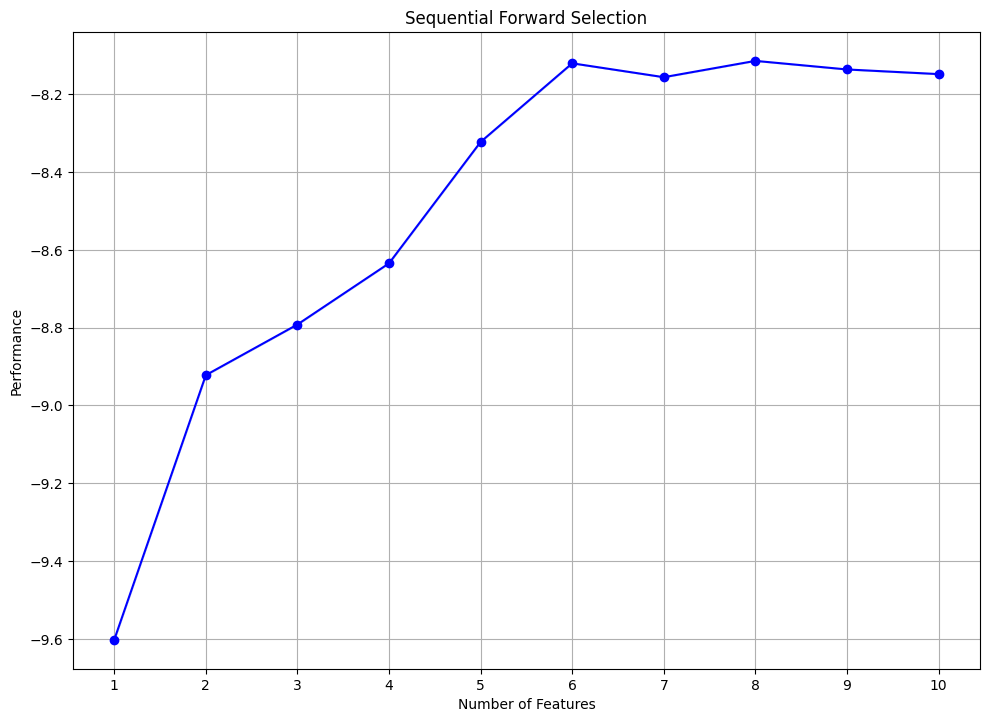

<Figure size 1170x827 with 0 Axes>

In [83]:
fig_sfs = plot_sfs(sfs.get_metric_dict())

plt.ylim()
plt.title('Sequential Forward Selection')
plt.grid()
plt.show() 
plt.savefig(os.path.join(ASSETS_DIR, 'fig_sfs.png'))


/home/andrey/work/MLE/mle-project-sprint-2-v001/.venv_sprint02/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/andrey/work/MLE/mle-project-sprint-2-v001/.venv_sprint02/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


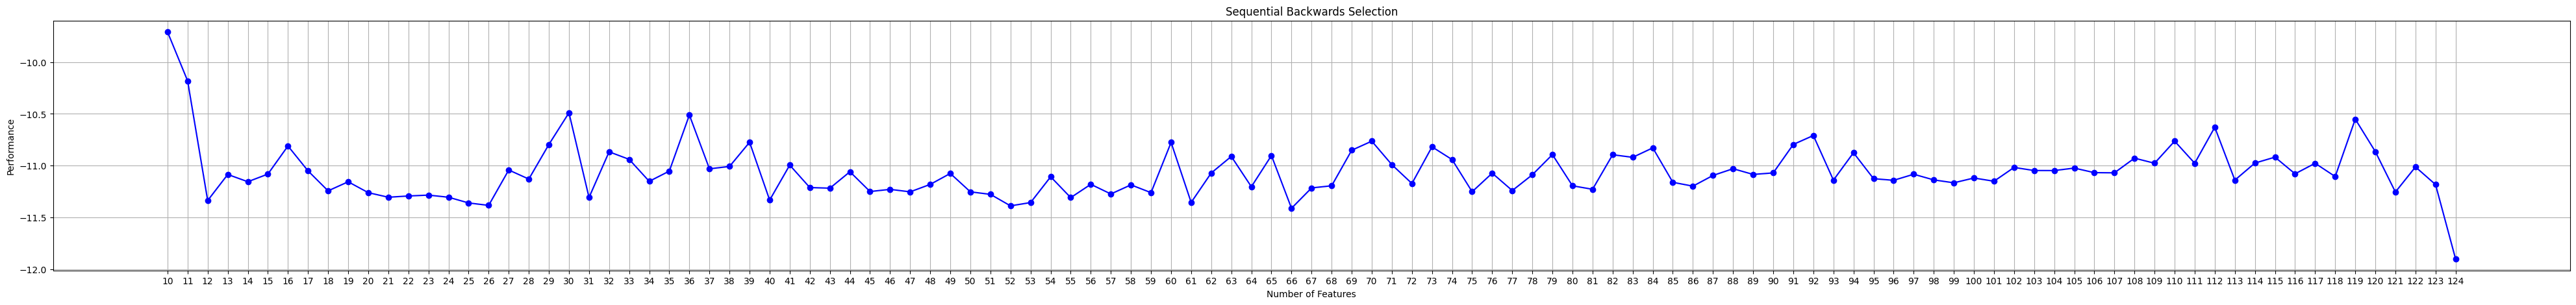

<Figure size 10000x500 with 0 Axes>

In [102]:
fig_sbs = plot_sfs(sbs.get_metric_dict())
plt.rcParams["figure.figsize"] = (100,5)
plt.ylim()
plt.title('Sequential Backwards Selection')
plt.grid()
plt.show() 
plt.savefig(os.path.join(ASSETS_DIR, 'fig_sbs.png'))

Использование признаков, полученных с помощью SBS показывает результат хуже, чем при SFS.

При этом, у всех трех способов есть общие признаки. 

Возьмем за основу RFECV и добавим признаки из SBS и SFS

In [141]:
rfecv_features = set([int(feature[1:]) for feature in rfecv.get_feature_names_out()])
sbs_features = set(sbs.k_feature_idx_)
sfs_features = set(sfs.k_feature_idx_)

selected_features = rfecv_features.union(sbs_features).union(sfs_features)
X_train_selected_features = X_train_preprocessed[:,list(selected_features)]
X_train_selected_features.shape

(83165, 68)

##### 4.4 Обучение новой версии модели

In [142]:
X_test_preprocessed = preprocessor.transform(X_test)
X_test_selected_features = X_test_preprocessed[:,list(selected_features)]

2024-05-14 10:25:05,441 INFO: [AutoFeat] Computing 8 new features.


2024-05-14 10:25:06,512 INFO: [AutoFeat]     8/    8 new features ...done.


In [144]:

model.fit(X_train_selected_features, y_train)
prediction = model.predict(X_test_selected_features)

metrics = {}
mae = mean_absolute_error(y_test, prediction).round(2)
mse = mean_squared_error(y_test, prediction).round(2)
mape = mean_absolute_percentage_error(y_test, prediction).round(2)
metrics["mae"] = mae
metrics["mse"] = mse
metrics["mape"] = mape


Learning rate set to 0.082325
0:	learn: 77726621.4005523	total: 55.6ms	remaining: 55.5s
1:	learn: 76951630.4181436	total: 61.1ms	remaining: 30.5s
2:	learn: 76294347.2412181	total: 67ms	remaining: 22.3s
3:	learn: 75652662.6811685	total: 72.3ms	remaining: 18s
4:	learn: 75121785.5607363	total: 78.6ms	remaining: 15.6s
5:	learn: 74584805.1763705	total: 84.4ms	remaining: 14s
6:	learn: 74151030.4498788	total: 90ms	remaining: 12.8s
7:	learn: 73574413.8367692	total: 95.7ms	remaining: 11.9s
8:	learn: 73237369.9707405	total: 102ms	remaining: 11.2s
9:	learn: 72819389.9780747	total: 108ms	remaining: 10.7s
10:	learn: 72560584.2697255	total: 114ms	remaining: 10.2s
11:	learn: 72117971.3729377	total: 120ms	remaining: 9.91s
12:	learn: 71889203.3746564	total: 127ms	remaining: 9.61s
13:	learn: 71602012.1430032	total: 133ms	remaining: 9.35s
14:	learn: 71300128.6860236	total: 139ms	remaining: 9.14s
15:	learn: 71119110.3665957	total: 146ms	remaining: 8.96s
16:	learn: 70945913.1339465	total: 152ms	remaining: 

##### 4.5 Логирование всех артефактов в MLflow

In [145]:

pip_requirements = "../requirements.txt"
metadata =  {'model_type': 'estate_regression'}
signature = mlflow.models.infer_signature(X_train_selected_features, prediction)
input_example = X_train_selected_features[:10]

RUN_NAME = 'feature_selection'
REGISTRY_MODEL_NAME = 'estate_model_feature_selection'
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    
    model_info = mlflow.sklearn.log_model( 
			sk_model=model,
            pip_requirements=pip_requirements,
            metadata=metadata,
            await_registration_for=60,
            input_example=input_example,
            signature=signature,
            artifact_path="models",
            registered_model_name=REGISTRY_MODEL_NAME)
    mlflow.log_artifact(ASSETS_DIR+'/fig_sbs.png')
    mlflow.log_artifact(ASSETS_DIR+'/fig_sfs.png')
    mlflow.log_artifact(ASSETS_DIR+'/rfecv.pkl')
    mlflow.log_artifact(ASSETS_DIR+'/sbs.pkl')
    mlflow.log_artifact(ASSETS_DIR+'/sfs.pkl')
    mlflow.log_metrics(metrics) 
run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024-05-14 10:33:23,097 INFO: Found credentials in environment variables.
Successfully registered model 'estate_model_feature_selection'.
2024/05/14 10:33:30 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: estate_model_feature_selection, version 1
Created version '1' of model 'estate_model_feature_selection'.


### Этап 5 - подбор гиперпараметров и обучение новой версии модели
После того как мы уделили значительное внимание качеству модели через создание и отбор признаков, пришло время для финального штриха — подбора гиперпараметров. Этот этап является ключевым в финальной части проекта второго спринта, где ваша задача — оптимизировать гиперпараметры модели для достижения наилучшего качества.

Рекомендуется подобрать гиперпараметры как минимум двумя различными методами (например, с использованием Grid Search и Random Search), чтобы вы могли сравнить результаты и выбрать наиболее эффективный набор гиперпараметров для вашей модели. После определения оптимальных гиперпараметров, наступает время обучить финальную версию модели, используя ваши новые признаки.

Рекомендуемые шаги:

- Выбор методов для подбора гиперпараметров: Определитесь с методами, которые вы будете использовать для подбора гиперпараметров (например, Grid Search, Random Search, Bayesian Optimization).
- Подбор гиперпараметров: Примените выбранные методы для нахождения оптимальных значений гиперпараметров вашей модели.
- Сравнение результатов: Анализируйте и сравнивайте результаты, полученные различными методами, для определения наилучшего набора гиперпараметров.
- Обучение финальной модели: Используя выбранные гиперпараметры, обучите финальную версию вашей модели на новых признаках.
- Документирование процесса и результатов: Залогируйте все шаги и результаты в MLflow, включая сравнение методов подбора гиперпараметров и характеристики финальной модели.

Этот этап позволит вам максимально улучшить качество вашей модели перед финальной оценкой, предоставив полное понимание важности и влияния гиперпараметров на производительность модели.

##### 5.1 Подбор гиперпарметров при мощи метода номер 1

In [226]:
import optuna
from optuna.integration.mlflow import MLflowCallback

from mlflow.utils.mlflow_tags import MLFLOW_PARENT_RUN_ID
from statistics import median
from sklearn.model_selection import KFold

In [234]:
RUN_NAME = "hyperparams_bayesian_search"

STUDY_DB_NAME = "sqlite:///local.study.db"
STUDY_NAME = "estate_study_optimize"
REGISTRY_MODEL_NAME = "estate_model_params"

In [235]:
def objective(trial: optuna.Trial) -> float:
    param = {
   "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
   "depth": trial.suggest_int("depth", 1, 12),
   "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.1, 5),
   "random_strength": trial.suggest_float("random_strength", 0.1, 5),
   "loss_function": "RMSE",
   "task_type": "CPU",
   "random_seed": 0,
   "iterations": 300,
   "verbose": False,
    }
    model = CatBoostRegressor(**param)

    skf = KFold(n_splits=3)

    metrics = {'mae':[], 
               'mse': [],
               'mape': []}
    
    for i, (train_index, val_index) in enumerate(skf.split(X_train_selected_features, y_train)):
        train_x = X_train_selected_features[train_index]
        train_y = y_train.iloc[train_index]
        val_x = X_train_selected_features[val_index]
        val_y = y_train.iloc[val_index]

        model.fit(train_x, train_y)
        prediction = model.predict(val_x)

        mae = mean_absolute_error(val_y, prediction).round(2)
        mse = mean_squared_error(val_y, prediction).round(2)
        mape = mean_absolute_percentage_error(val_y, prediction).round(2)

        
        metrics["mae"].append(mae)
        metrics["mse"].append(mse)
        metrics["mape"].append(mape)


        
    mae = median((metrics['mae']))	
    mse = median((metrics['mse']))	
    mape = median((metrics['mape']))	
    
    metrics = {'mae':mae, 
               'mse': mse,
               'mape': mape, 
               }

    return mape

In [236]:

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    model_info = mlflow.sklearn.log_model( 
            sk_model=model,
            artifact_path="cv",
            registered_model_name=REGISTRY_MODEL_NAME)

mlflc = MLflowCallback(
    tracking_uri=tracking_uri,
    metric_name="mape",
    create_experiment=False,
    mlflow_kwargs={'experiment_id': experiment_id, 'tags': {MLFLOW_PARENT_RUN_ID:run_id}}
)


study = optuna.create_study(direction='minimize', study_name=STUDY_NAME, storage=STUDY_DB_NAME, load_if_exists=True)
study.optimize(objective, n_trials=20, callbacks=[mlflc])
best_params =  study.best_trial.params

print(f"Number of finished trials: {len(study.trials)}")
print(f"Best params: {best_params}")

Registered model 'estate_model_params' already exists. Creating a new version of this model...
2024/05/14 15:05:23 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: estate_model_params, version 3
Created version '3' of model 'estate_model_params'.
/tmp/ipykernel_451403/1554061819.py:10: ExperimentalWarning: MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.
  mlflc = MLflowCallback(
[I 2024-05-14 15:05:24,121] A new study created in RDB with name: estate_study_optimize
[I 2024-05-14 15:06:04,591] Trial 0 finished with value: 8.68 and parameters: {'learning_rate': 0.0036332209099495024, 'depth': 9, 'l2_leaf_reg': 0.16216236780794405, 'random_strength': 4.178013724693391}. Best is trial 0 with value: 8.68.
[I 2024-05-14 15:06:10,312] Trial 1 finished with value: 6.83 and parameters: {'learning_rate': 0.04771730159971175, 'depth': 2, 'l2_leaf_reg': 2.5760301786755386, 'rando

Number of finished trials: 20
Best params: {'learning_rate': 0.08815836927085877, 'depth': 12, 'l2_leaf_reg': 2.825939735688586, 'random_strength': 0.21934480144756574}


##### 5.2 Подбор гиперпарметров при мощи метода номер 2

In [164]:
import numpy as np  
from sklearn.model_selection import RandomizedSearchCV

In [172]:


param_distributions = {
     "learning_rate": np.linspace(0.001, 0.1),
     "depth": np.arange(1, 12),
     "l2_leaf_reg": np.linspace(0.1, 5),
     "random_strength": np.linspace (0.1, 5),
}


model = CatBoostRegressor(random_seed=0)

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, cv=2,n_jobs=-1, n_iter=20, scoring='neg_mean_absolute_percentage_error')
random_search.fit(X_train_selected_features, y_train)


print("Лучшие гиперпараметры:", random_search.best_params_)
print("Лучший результат:", random_search.best_score_)



0:	learn: 79068537.0112699	total: 260ms	remaining: 4m 19s
1:	learn: 78317983.2652244	total: 433ms	remaining: 3m 36s
2:	learn: 77592125.2544362	total: 589ms	remaining: 3m 15s
3:	learn: 76988522.2384012	total: 744ms	remaining: 3m 5s
4:	learn: 76544518.6247803	total: 895ms	remaining: 2m 58s
5:	learn: 76142543.9666157	total: 1.03s	remaining: 2m 51s
6:	learn: 75788092.1238331	total: 1.17s	remaining: 2m 45s
7:	learn: 75387508.2124629	total: 1.32s	remaining: 2m 43s
8:	learn: 75033366.7247938	total: 1.46s	remaining: 2m 40s
9:	learn: 74144615.2391800	total: 1.6s	remaining: 2m 38s
10:	learn: 73836061.4531623	total: 1.75s	remaining: 2m 37s
11:	learn: 73608340.5495604	total: 1.9s	remaining: 2m 36s
12:	learn: 73389868.0336701	total: 2.05s	remaining: 2m 35s
13:	learn: 72662290.3982485	total: 2.19s	remaining: 2m 34s
14:	learn: 72425492.9574866	total: 2.34s	remaining: 2m 33s
15:	learn: 72301553.0461127	total: 2.5s	remaining: 2m 34s
16:	learn: 72016999.6523428	total: 2.67s	remaining: 2m 34s
17:	learn: 

##### 5.3 Формирование списка гиперпараметров для новой модели

In [237]:
rs_best_params = random_search.best_params_
opt_best_params = best_params


In [257]:
print('random search best params =', rs_best_params)
print('optuna best params =', opt_best_params)

random search best params = {'random_strength': 3.3000000000000003, 'learning_rate': 0.08383673469387756, 'l2_leaf_reg': 4.9, 'depth': 5}
optuna best params = {'learning_rate': 0.08815836927085877, 'depth': 12, 'l2_leaf_reg': 2.825939735688586, 'random_strength': 0.21934480144756574}


Видим, что параметры сильно разнятся кроме learning_rate. Оптимальные будем смотреть по тестовой выборке. Обучим  и залогируем две модели

In [186]:
model_rs = CatBoostRegressor(**rs_best_params)
model_rs.fit(X_train_selected_features, y_train)

prediction_rs = model_rs.predict(X_test_selected_features)

metrics_rs = {}
mae = mean_absolute_error(y_test, prediction_rs).round(2)
mse = mean_squared_error(y_test, prediction_rs).round(2)
mape = mean_absolute_percentage_error(y_test, prediction_rs).round(2)
metrics_rs["mae"] = mae
metrics_rs["mse"] = mse
metrics_rs["mape"] = mape



0:	learn: 77861612.7624113	total: 9.91ms	remaining: 9.9s
1:	learn: 77170056.6794408	total: 16.4ms	remaining: 8.17s
2:	learn: 76581612.5042980	total: 22.8ms	remaining: 7.57s
3:	learn: 76035524.0633556	total: 29.8ms	remaining: 7.41s
4:	learn: 75589260.1786735	total: 35.4ms	remaining: 7.04s
5:	learn: 75196249.2071765	total: 40.7ms	remaining: 6.74s
6:	learn: 74814829.4462974	total: 46.8ms	remaining: 6.64s
7:	learn: 74563430.0112050	total: 53.1ms	remaining: 6.58s
8:	learn: 74294221.7781336	total: 57.6ms	remaining: 6.35s
9:	learn: 74028387.9119820	total: 63ms	remaining: 6.24s
10:	learn: 73787074.2122664	total: 68ms	remaining: 6.11s
11:	learn: 73556815.2065447	total: 72.8ms	remaining: 6s
12:	learn: 73398655.0888586	total: 77.9ms	remaining: 5.91s
13:	learn: 73203408.5819478	total: 82.3ms	remaining: 5.79s
14:	learn: 73025981.2543416	total: 86.6ms	remaining: 5.69s
15:	learn: 72879698.7358915	total: 93ms	remaining: 5.72s
16:	learn: 72752210.5882101	total: 98.7ms	remaining: 5.71s
17:	learn: 725965

{'mae': 5509377.14, 'mse': 2192349936497964.8, 'mape': 28.18}

In [266]:

pip_requirements = "../requirements.txt"
metadata =  {'model_type': 'estate_regression'}
signature = mlflow.models.infer_signature(X_train_selected_features, prediction)
input_example = X_train_selected_features[:10]

RUN_NAME = 'hyperparams_random_search'

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    
    model_info = mlflow.sklearn.log_model( 
			sk_model=model_rs,
            pip_requirements=pip_requirements,
            metadata=metadata,
            await_registration_for=60,
            input_example=input_example,
            signature=signature,
            artifact_path="models",
            registered_model_name=REGISTRY_MODEL_NAME,
            )
    mlflow.log_metrics(metrics_rs) 
    mlflow.log_params(rs_best_params)
run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

Registered model 'estate_model_params' already exists. Creating a new version of this model...
2024/05/14 15:55:49 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: estate_model_params, version 5
Created version '5' of model 'estate_model_params'.


In [238]:
model_opt = CatBoostRegressor(**opt_best_params)
model_opt.fit(X_train_selected_features, y_train)

prediction_opt = model_opt.predict(X_test_selected_features)

metrics_opt = {}
mae = mean_absolute_error(y_test, prediction_opt).round(2)
mse = mean_squared_error(y_test, prediction_opt).round(2)
mape = mean_absolute_percentage_error(y_test, prediction_opt).round(2)
metrics_opt["mae"] = mae
metrics_opt["mse"] = mse
metrics_opt["mape"] = mape



0:	learn: 77177879.1092339	total: 277ms	remaining: 4m 36s
1:	learn: 76006428.0482868	total: 574ms	remaining: 4m 46s
2:	learn: 74726991.5611399	total: 871ms	remaining: 4m 49s
3:	learn: 73638192.0329875	total: 1.18s	remaining: 4m 54s
4:	learn: 72532331.0439992	total: 1.48s	remaining: 4m 54s
5:	learn: 71621771.9885091	total: 1.78s	remaining: 4m 54s
6:	learn: 70700041.3760526	total: 2.07s	remaining: 4m 54s
7:	learn: 69849359.0300453	total: 2.36s	remaining: 4m 52s
8:	learn: 69008588.8534940	total: 2.64s	remaining: 4m 51s
9:	learn: 68241013.3066901	total: 2.93s	remaining: 4m 50s
10:	learn: 67522194.3853491	total: 3.23s	remaining: 4m 50s
11:	learn: 67063196.4610820	total: 3.52s	remaining: 4m 49s
12:	learn: 66549387.7340765	total: 3.8s	remaining: 4m 48s
13:	learn: 65963546.5277538	total: 4.12s	remaining: 4m 49s
14:	learn: 65378785.2052347	total: 4.46s	remaining: 4m 52s
15:	learn: 65029332.8691495	total: 4.78s	remaining: 4m 53s
16:	learn: 64462170.0758146	total: 5.07s	remaining: 4m 53s
17:	lear

{'mae': 4792990.31, 'mse': 1578658867148864.8, 'mape': 26.1}

##### 5.4 Обуение финальной версии модели

и

##### 5.5 Логирование артефактов в MLflow

Поскольку модель с гиперпараметрами, полученными optuna, оказалась лучше, считаем ее финальной и создаем финальный пайплайн с ней

In [280]:

with open(ASSETS_DIR+'/selected_features.txt', 'w') as f:
    for line in selected_features:
        f.write(f"{line}\n")

In [282]:
pipeline_final = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', model_opt)
    ]
)


pip_requirements = "../requirements.txt"
metadata =  {'model_type': 'estate_regression'}
signature = mlflow.models.infer_signature(X_train_selected_features, prediction)
input_example = X_train[:10]

RUN_NAME = 'final_pipeline'

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    
    model_info = mlflow.sklearn.log_model( 
			sk_model=pipeline_final,
            pip_requirements=pip_requirements,
            metadata=metadata,
            await_registration_for=60,
            input_example=input_example,
            signature=signature,
            artifact_path="models",
            registered_model_name=REGISTRY_MODEL_NAME,
            )
    mlflow.log_metrics(metrics_opt) 
    mlflow.log_params(opt_best_params)
    mlflow.log_artifact()
run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

Registered model 'estate_model_params' already exists. Creating a new version of this model...
2024/05/15 11:11:32 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: estate_model_params, version 8
Created version '8' of model 'estate_model_params'.
